In [4]:
pip install pandas numpy matplotlib seaborn plotly statsmodels scikit-learn

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.5 MB 8.5 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.5 MB 9.1 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.5 MB 9.9 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.5 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Loading Data ---
Data Loaded. Analysis Range: 2022-02-25 to 2025-11-30

--- Generating Exploratory Plots ---


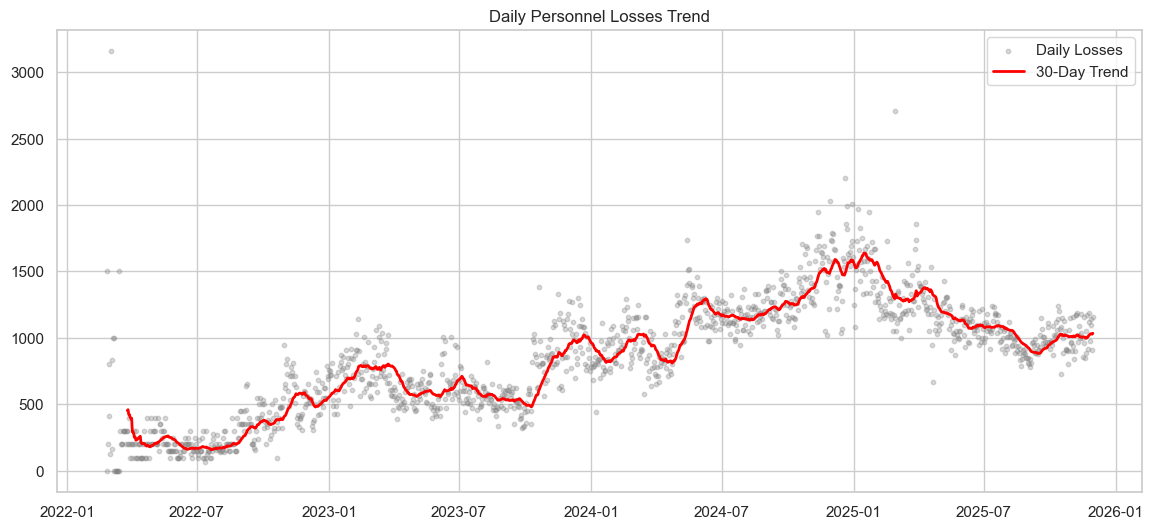

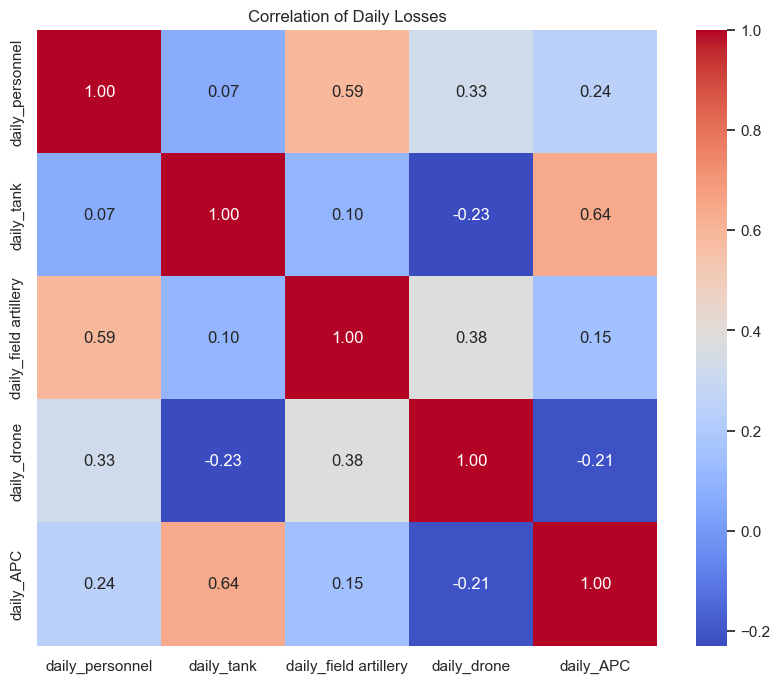


--- Running 2026 Scenario Forecast ---
Analysis Complete.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import itertools
import warnings
import plotly.io as pio
pio.renderers.default = "browser"

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# ==========================================
# 1. DATA LOADING & PREPROCESSING
# ==========================================
print("--- Loading Data ---")
df = pd.read_csv('russian_losses.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calculate DAILY losses (diff from cumulative)
cols_to_track = ['personnel', 'tank', 'APC', 'field artillery',
                 'vehicles and fuel tanks', 'drone', 'cruise missiles']

daily_df = pd.DataFrame()
daily_df['date'] = df['date']

for col in cols_to_track:
    # We use f-string to create clear column names like 'daily_tank'
    daily_df[f'daily_{col}'] = df[col].diff().fillna(0)

daily_df.set_index('date', inplace=True)

# Filter anomalies (remove negative values from data corrections)
daily_df = daily_df[(daily_df >= 0).all(axis=1)]

print(f"Data Loaded. Analysis Range: {daily_df.index.min().date()} to {daily_df.index.max().date()}")

# ==========================================
# 2. EXPLORATORY VISUALIZATION
# ==========================================
print("\n--- Generating Exploratory Plots ---")

# Plot 1: Daily Trend vs 30-Day Avg
plt.figure(figsize=(14, 6))
plt.scatter(daily_df.index, daily_df['daily_personnel'], alpha=0.3, color='gray', s=10, label='Daily Losses')
plt.plot(daily_df.index, daily_df['daily_personnel'].rolling(30).mean(), color='red', linewidth=2, label='30-Day Trend')
plt.title('Daily Personnel Losses Trend')
plt.legend()
plt.show()

# Plot 2: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_cols = ['daily_personnel', 'daily_tank', 'daily_field artillery', 'daily_drone', 'daily_APC']
sns.heatmap(daily_df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Daily Losses')
plt.show()

# ==========================================
# 3. ADVANCED MODELING: SCENARIO FORECAST
# ==========================================
print("\n--- Running 2026 Scenario Forecast ---")

# A. Train Link Model (Personnel ~ Equipment)
features = ['daily_tank', 'daily_APC', 'daily_field artillery', 'daily_vehicles and fuel tanks']
target = 'daily_personnel'

X = daily_df[features]
y = daily_df[target]

link_model = LinearRegression()
link_model.fit(X, y)

# B. Generate 3 Futures for Equipment
dates_2026 = pd.date_range(start='2026-01-01', end='2026-12-31', freq='D')
scenarios = {} # Dictionary to store our 3 scenarios

# Scenario A: Status Quo (Last 90 Days Average)
scenarios['Status Quo'] = pd.DataFrame(index=dates_2026, columns=features)
for col in features:
    scenarios['Status Quo'][col] = daily_df[col].tail(90).mean()

# Scenario B: Linear Trend (Projection)
scenarios['Linear Trend'] = pd.DataFrame(index=dates_2026, columns=features)
day_ordinals = (daily_df.index - daily_df.index.min()).days.values.reshape(-1, 1)
future_ordinals = (dates_2026 - daily_df.index.min()).days.values.reshape(-1, 1)

for col in features:
    reg = LinearRegression().fit(day_ordinals, daily_df[col])
    pred = reg.predict(future_ordinals)
    scenarios['Linear Trend'][col] = np.maximum(pred, 0) # Clip negative values

# Scenario C: ARIMA Cycles
scenarios['ARIMA'] = pd.DataFrame(index=dates_2026, columns=features)
for col in features:
    # Simple (1,1,1) for speed, can be optimized
    model = ARIMA(daily_df[col], order=(1,1,1)).fit()
    pred = model.forecast(steps=365)
    # Fix: Assign values directly to avoid index misalignment causing NaNs
    scenarios['ARIMA'][col] = np.maximum(pred.values, 0)

# C. Predict Personnel for Each Scenario
results = pd.DataFrame(index=dates_2026)
for name, data in scenarios.items():
    results[name] = link_model.predict(data)

# Resample to Monthly for Visualization
monthly_results = results.resample('M').sum()

# ==========================================
# 4. FINAL VISUALIZATION (Plotly)
# ==========================================
fig = go.Figure()

colors = {'Status Quo': 'gray', 'Linear Trend': 'blue', 'ARIMA': 'red'}
styles = {'Status Quo': 'dash', 'Linear Trend': 'solid', 'ARIMA': 'solid'}

for scenario in monthly_results.columns:
    total = monthly_results[scenario].sum()
    fig.add_trace(go.Scatter(
        x=monthly_results.index.strftime('%B'),
        y=monthly_results[scenario],
        mode='lines+markers',
        name=f"{scenario} (Total: {total:,.0f})",
        line=dict(color=colors[scenario], dash=styles.get(scenario, 'solid'), width=3)
    ))

fig.update_layout(
    title="2026 Personnel Loss Scenarios",
    yaxis_title="Monthly Personnel Losses",
    template="plotly_white",
    hovermode='x unified'
)

fig.show()
print("Analysis Complete.")